# Boosting Methods

Creating a strong classifier from a bunch(ensemble) of weak classifiers.

**Basic concept is to build a second model correcting the errors made by the first model.**

## Adaboost

References 
- [StatQuest with Josh Starmer ](https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw)

As compared to Random Forest
- In random forest a bunch of decision trees are selected and these trees are full sized trees but of different sizes with no predetermined depths.
- In random forest each tree has equal weight/vote on final classification.
- In random forest each decision tree is independent to the other trees.

**Adaptive Boosting**

- In Adaboost forest of trees used, are trees with just one node and two leaves, called `stump`.(we can say that it is a forest of stumps)
```
              ________
             |Question|
             |________|
            /          \
   ________/            \________
  |___Yes__|            |___No___| 
```
- Stumps is basically a weak learners, bad classifiers as they have only one feature to learn upon and the results are inconclusive mostly.
- But Adaboost needs bad learners only.
- In Adaboost some stumps get `more say` in the classification that others.
- In Adaboost stumps are dependent. How? Error made by first stump determines how the second stump will be made, and second will influence the third one and so on.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [15]:
n_samples = 10
n_features = 4
X,y = make_classification(n_samples=n_samples,n_features=n_features)

X.shape, y.shape

((10, 4), (10,))

### Sample weight

At start all samples get the same weight.

sample weight = $\frac{1}{n_{samples}}$

### Total error(TE)

sum of sample weights for wrongly classified samples gives Total Error of the stump.

### Amount of say


Amount of Say = $\frac{1}{2} \log(\frac{1 - TE}{TE})$

As the name suggests what is the amount of say that a stump has, with Total Error(TE).

In [17]:
def amount_of_say(total_error):   
    return np.log((1 - total_error)/total_error)/2

plotting amount of say vs total error graph

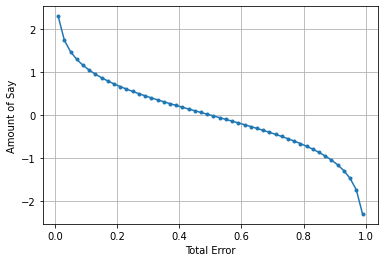

In [36]:
%matplotlib inline
te = np.linspace(0.01,0.99,num=50)
aos = amount_of_say(te)

ax = plt.subplot(111)
ax.plot(te,aos,'.-')

ax.set_xlabel("Total Error")
ax.set_ylabel("Amount of Say")

plt.grid()
plt.show()

It is visible from the graph that when total error is less, amount of say is high and when total error is high amount of say decreases.

lets say if the total error is 0.5(50-50), then amount of say is 0. that means this stump doesn't matter to the final results.

### Updating Sample weight

New Sample Weight = Sample Weight x $e^{\text{amount of say}}$

In [37]:
def update_sample_weight(sample_weight, amount_of_say):
    return sample_weight * np.exp(amount_of_say)

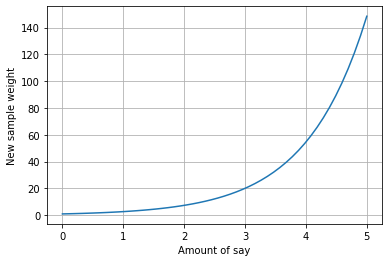

In [42]:

plt.plot(np.linspace(0,5,50),np.exp(np.linspace(0,5,50)))
plt.xlabel("Amount of say")
plt.ylabel("New sample weight")
plt.grid()

So the new sample weight will be little larger than the sample weight for the positive amount of say.